# Definitions

In [1]:
# Metrics
import os
import sys
import pandas as pd
import numpy as np
from collections import defaultdict
from itertools import zip_longest
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
np.set_printoptions(edgeitems=1000, linewidth=100000, 
    formatter=dict(float=lambda x: "%.1f" % x))
plt.rc('font', family='serif')

## Formatter

In [60]:
def fmt_div_e5(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{}'.format(x / 100000)
    return s


def fmt_div_e3(x, pos): # your custom formatter function: divide y axis tick labels by 1000.0
    s = '{}'.format(x / 1000)
    return s


def fmt_div_e7(x, pos): # your custom formatter function: divide y axis tick labels by 10000000.0
    s = '{}'.format(x / 10000000)
    return s


def fmt_div_e9(x, pos): # your custom formatter function: divide y axis tick labels by 10000000.0
    s = '{}'.format(x / 1e+9)
    return s

def fmt_mul_e2(x, pos): # your custom formatter function: multiply y axis tick labels by 100.0
    s = '{}'.format(x * 100)
    return s


def ms_to_min(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{:.2f}'.format(x / 60000)
    return s

def ms_to_sec(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{:.2f}'.format(x / 1000)
    return s

def sec_to_min(x, pos): # your custom formatter function: divide y axis tick labels by 100000.0
    s = '{:.2f}'.format(x / 60)
    return s

## Plotter


In [28]:
def plot_aggregated_dict(title, inputs, labels, markers, linestyles, colors, fit_degree=None, formatter=None, ylabel=None, xlabel=None, pre_fig=None):
    x = np.array(sorted(inputs[0].keys()))
    y = list(map(lambda x: np.array([]), inputs))
    lines = list()
    for key in x:
        for i, _ in enumerate(y):
            if key not in inputs[i]:
                inputs[i][key] = 0
            val = np.array(inputs[i][key])
            y[i] = np.append(y[i], val)
    fig, ax = plt.subplots() if pre_fig is None else pre_fig
    for i, yi in enumerate(y):
        if fit_degree:
            theta = np.poly1d(np.polyfit(x, y[i], fit_degree))
            fit_line = theta(x)
            lines.append(ax.scatter(x, yi, label=labels[i], marker=markers[i], color=colors[i], linestyle=linestyles[i]))
            lines.append(ax.plot(x, fit_line, label=None, marker=None, linestyle=":")[0])
        else:
            lines.append(ax.plot(x, yi, label=labels[i], marker=markers[i], color=colors[i], linestyle=linestyles[i])[0])
    if formatter is not None:
        ax.yaxis.set_major_formatter(formatter)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return (fig, ax, lines)

def plot_with_text():
    pass

def get_legend(ax, ncol=3, file_name=None ):
    fig_leg = plt.figure(figsize=(1, 0))
    ax_leg = fig_leg.add_subplot(111)
    ax_leg.axis('off')
    ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', ncol=ncol)
    if file_name is not None:
        fig_leg.savefig(file_name, dpi=300, bbox_inches='tight', pad_inches=0)
    return fig_leg

## Statistics Measurer

In [57]:
class MetricStatistics:
    def __init__(self, entry_folder_name="metrics", operator_name="GNN Operator - 2", metric_name="numRecordsInPerSecond", is_lambda=False):
        """ 
        Folders are organized as follows:
        entry_folder -> run -> operator_name -> metric_name -> subtask_index[digit]
        Output is as follows:
        parallelism -> experiments[] -> subtask[] -> metric_values[]
        """
        self.output = defaultdict(list)
        for run in os.listdir(entry_folder_name):
            if not os.path.isdir(os.path.join(entry_folder_name, run)):
                continue
            subtasks = []
            for subtask_index in (os.listdir(os.path.join(entry_folder_name, run, operator_name, metric_name))):
                if not subtask_index.isdigit():
                    continue
                f = pd.read_csv(os.path.join(entry_folder_name, run, operator_name, metric_name,subtask_index), header=None, names=["value"])
                subtasks.append(f["value"].values)
                
            run_class = int(re.match(".*\((\d+)\).*",run).groups()[0]) if not is_lambda else float(re.match(".*-l=(\d+.\d+).*",run).groups()[0])
            self.output[run_class].append(subtasks)
            
    def __apply_common_fn(self, transformation:str, data, *args, **kwargs):
        if transformation == "trim_zeros":
            return np.trim_zeros(data, "fb", *args, **kwargs)
        elif transformation == "trim_zeros_back":
            return np.trim_zeros(data, "b", *args, **kwargs)
        elif transformation == "trim_zeros_front":
            return np.trim_zeros(data, "f", *args, **kwargs)
        elif transformation == "mean":
            return np.nanmean(data, *args, **kwargs)
        elif transformation == "max":
            return np.nanmax(data, *args, **kwargs)
        elif transformation == "sum":
            return np.nansum(data, *args, **kwargs)
        elif transformation == "min":
            return np.nanmin(data, *args, **kwargs)
        elif transformation == "var":
            return np.nanvar(data, *args, **kwargs)
        elif transformation == "std":
            return np.nanstd(data, *args, **kwargs)
        elif transformation == "expand_dim":
            return np.expand_dims(data, -1, *args, **kwargs)
        else:
            raise Exception("Not found")
        
    def transform_metrics(self, transformation):
        """ Apply Transformation to each metric array in a subtask """
        for experiments in self.output.values():
            for experiment in experiments:
                for subtask_index in range(len(experiment)):
                    if callable(transformation):
                        experiment[subtask_index] = transformation(experiment[subtask_index])
                    else:
                        experiment[subtask_index] = self.__apply_common_fn(transformation, experiment[subtask_index])
        return self
        
    def transform_subtasks(self, transformation):
        """ Apply transformation to all subtasks """
        for experiments in self.output.values():
            for experiment_index in range(len(experiments)):
                if callable(transformation):
                    experiments[experiment_index] = transformation(experiments[experiment_index])
                elif "_axis" in transformation:
                    max_len = max([len(x) for x in experiments[experiment_index]])
                    data = np.vstack([np.pad(x.astype(float), (0, max_len - len(x)), constant_values=np.nan) for x in experiments[experiment_index]])
                    real_transformation, axis = transformation.split("_")[0], int(transformation.split("_")[1])
                    experiments[experiment_index] = self.__apply_common_fn(real_transformation, data, axis=axis)
                else:
                    experiments[experiment_index] = self.__apply_common_fn(transformation, experiments[experiment_index])                
        return self
    
    def transform_experiment(self, transformation):
        """ Apply transformation to all experiments """
        for key, experiments in self.output.items():
            if callable(transformation):
                self.output[key] = transformation(experiments)
            elif "_axis" in transformation:
                max_len = max([len(x) for x in experiments])
                data = np.vstack([np.pad(x.astype(float), (0, max_len - len(x)), constant_values=np.nan) for x in experiments])
                real_transformation, axis = transformation.split("_")[0], int(transformation.split("_")[1])
                self.output[key] = self.__apply_common_fn(real_transformation, data, axis=axis)
            else:
                self.output[key] = self.__apply_common_fn(transformation, experiments)
        return self
    
    def transform_keys(self, transformation = lambda x: x // 10):
        """ Transform the keys """
        self.output = {transformation(key):value for key,value in self.output.items()}
        return self
        
    def get_computation_std(self):
        """ Get Variance of max """
        self.transform_metrics(lambda x: x[(x < 1000).nonzero()[0][0] : -1]).transform_metrics("trim_zeros").transform_metrics("mean")
        self.transform_metrics("expand_dim")
        self.transform_subtasks("std_0_axis")
        self.transform_experiment("mean_0_axis")
        return self
    
    def get_computation_imbalance_factor(self):
        """ Max_load / Min_load """
        self.transform_metrics(lambda x: x[(x < 1000).nonzero()[0][0] : -1]).transform_metrics("trim_zeros").transform_metrics("mean")
        self.transform_subtasks(lambda x: np.array(max(x) / min(x)))
        return self.transform_experiment("mean")
    
    def get_communication_std(self):
        """ Get Variance of max """
        self.transform_metrics("max")
        self.transform_metrics("expand_dim")
        self.transform_subtasks("std_0_axis")
        self.transform_experiment("mean_0_axis")
        return self
    
    def get_communication_imbalance_factor(self):
        """ Get imbalance of communication """
        self.transform_metrics("max")
        self.transform_subtasks(lambda x: np.array(max(x) / min(x)))
        return self.transform_experiment("mean")
    
    def get_communication_volume(self):
        """ Get Communication volume """
        self.transform_metrics("max")
        self.transform_subtasks("sum")
        return self.transform_experiment("mean")
    
    def get_mean_throughput(self):
        """ Get Mean Throughput """
        self.transform_metrics("trim_zeros")
        self.transform_subtasks("sum_0_axis")
        self.transform_subtasks(lambda x: np.array([x.mean()]))
        return self.transform_experiment("mean_0_axis").transform_experiment(lambda a: a[0])
    
    def get_max_throughput(self):
        """ Get Max Throughput """
        self.transform_metrics("trim_zeros")
        self.transform_subtasks("sum_0_axis")
        self.transform_subtasks(lambda x: np.array([x.max()]))
        return self.transform_experiment("mean_0_axis").transform_experiment(lambda a: a[0])
        
   
    def get_replication_factor(self):
        """ Get Partitioner Replication Factor """
        self.transform_metrics(lambda x: np.array([x[-1]]))
        self.transform_subtasks("mean")
        self.transform_experiment("mean")
        return self
    
    def get_runtime(self):
        """ Get runtime of this operator """
        self.transform_metrics("trim_zeros").transform_metrics(lambda x: np.array([x.shape[0]]))
        self.transform_subtasks("max")
        self.transform_experiment("mean")
        return self
    
    def get_mean_latency(self):
        """ Get latency of this operator """
        self.transform_metrics("trim_zeros")
        self.transform_subtasks("mean_0_axis")
        self.transform_subtasks("mean")
        return self.transform_experiment("mean")
    
    def get_evolution_latency(self):
        """ Get latency evolution of each operator """
        self.transform_metrics("trim_zeros")
        self.transform_subtasks("mean_0_axis")
        return self.transform_experiment("min_0_axis")
        
    def get_accuracy(self):
        """ Get runtime of this operator """
        self.transform_metrics("trim_zeros_back")
        self.transform_metrics("trim_zeros_front")
        self.transform_subtasks("mean_0_axis")
        self.transform_experiment("mean_0_axis")
        return self
    

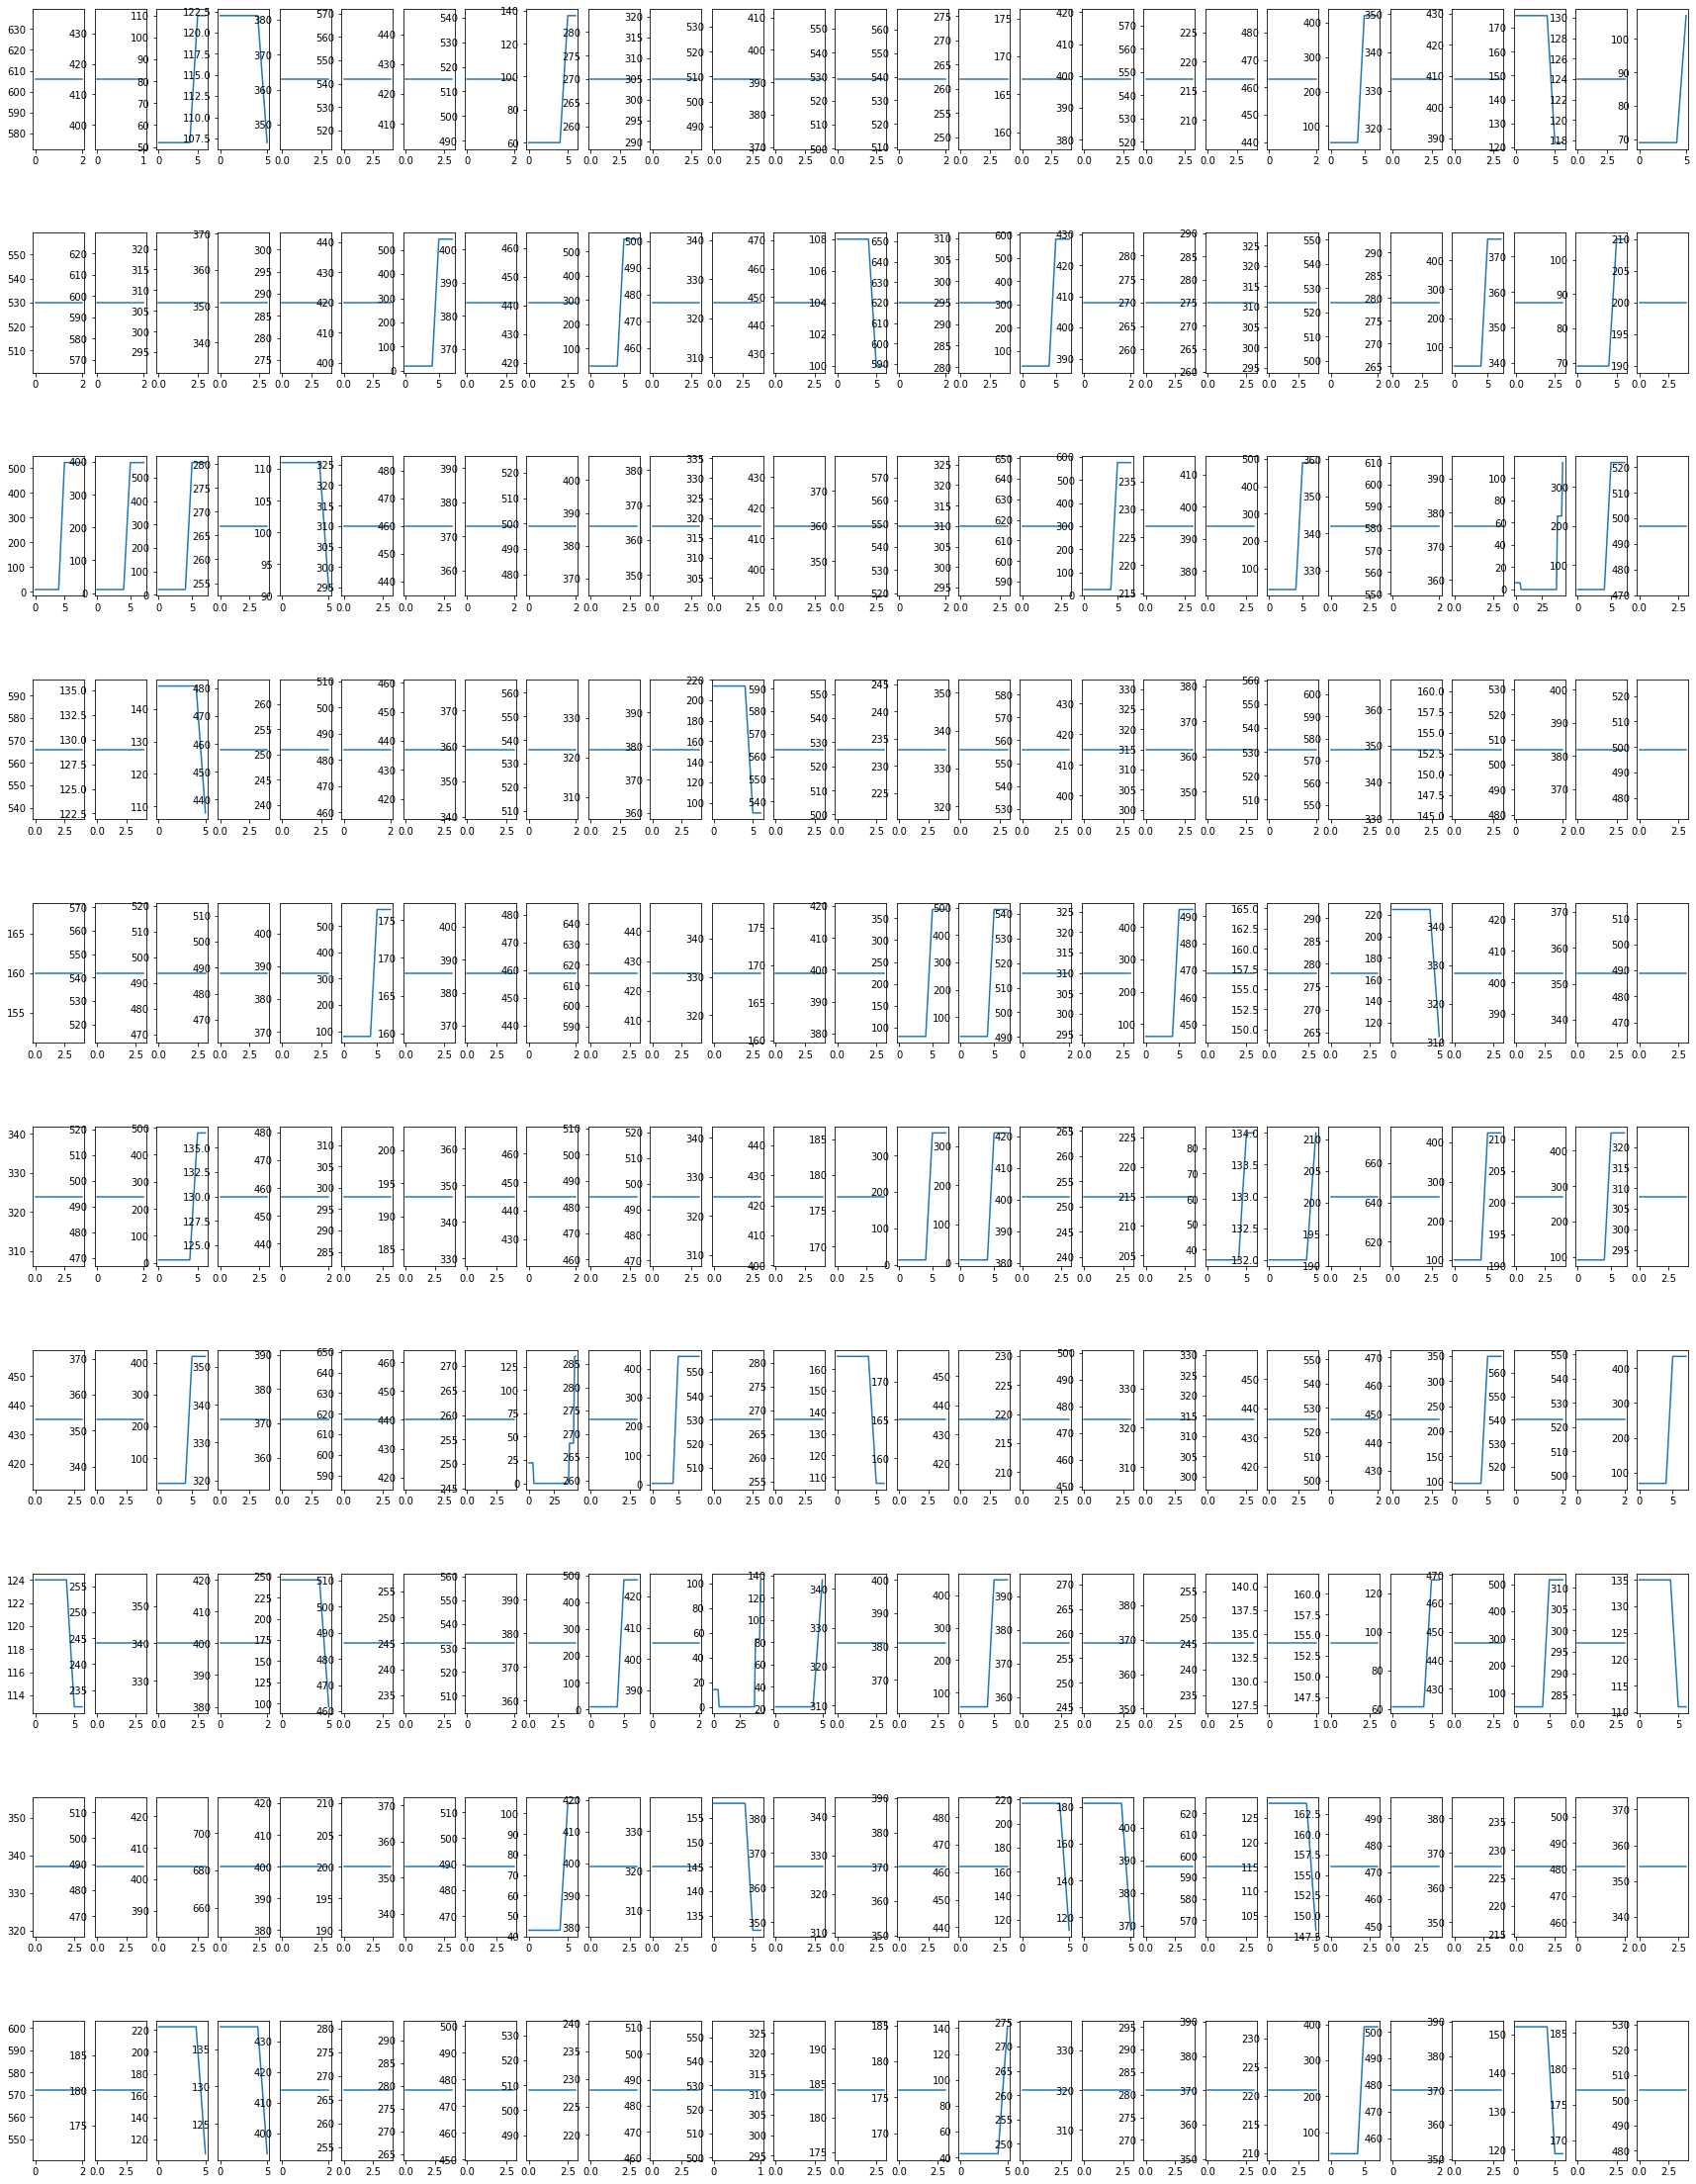

In [29]:
fig, ax = plt.subplots(10,27, figsize=(30,40), gridspec_kw={"hspace":0.6})
for i in range(10):
    for j in range(27):
        ax[i][j].plot(a1.output[90][0][j*10 + i])

In [56]:
fig.subplots_adjust(wspace=0.4)
t1 = fig.text(0.08, 0.5, 'Imbalance Factor', va='center', rotation='vertical')
t2 = fig.text(0.5, 0, '# Machines', ha='center')
fig.savefig('sx-superuser_imbalance_factor.png', dpi=300, bbox_inches='tight', pad_inches=0.05)

In [54]:
t2.remove()

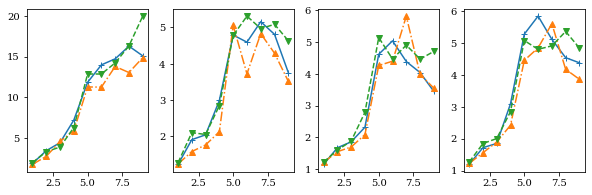

In [55]:
fig.subplots_adjust(wspace=0.2)
fig

### Latency

(<Figure size 720x216 with 4 Axes>,
 <AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7feb07f16a30>])

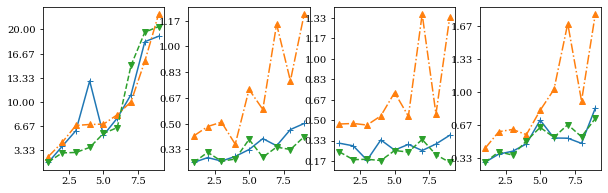

In [61]:
fig, ax = plt.subplots(1,4, figsize=(10,3))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming HDRF/", metric_name="latency").get_mean_latency().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming Random/", metric_name="latency").get_mean_latency().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming CLDA/", metric_name="latency").get_mean_latency().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=ms_to_min, pre_fig=(fig,ax[0]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 HDRF/", metric_name="latency").get_mean_latency().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 Random/", metric_name="latency").get_mean_latency().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 CLDA/", metric_name="latency").get_mean_latency().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=ms_to_min, pre_fig=(fig,ax[1]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 HDRF/", metric_name="latency").get_mean_latency().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 Random/", metric_name="latency").get_mean_latency().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 CLDA/", metric_name="latency").get_mean_latency().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=ms_to_min, pre_fig=(fig,ax[2]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 HDRF/", metric_name="latency").get_mean_latency().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 Random/", metric_name="latency").get_mean_latency().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 CLDA/", metric_name="latency").get_mean_latency().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=ms_to_min, pre_fig=(fig,ax[3]))


### Throughput

(<Figure size 720x216 with 4 Axes>,
 <AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7feb0c9e0040>])

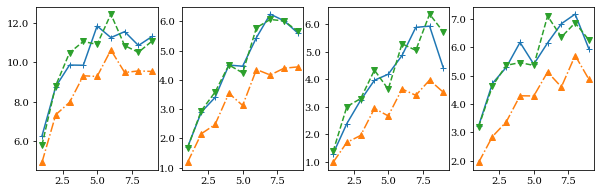

In [8]:
fig, ax = plt.subplots(1,4, figsize=(10,3))

a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming HDRF/", metric_name="throughput").get_mean_throughput().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming Random/", metric_name="throughput").get_mean_throughput().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming CLDA/", metric_name="throughput").get_mean_throughput().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=fmt_div_e5, pre_fig=(fig,ax[0]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 HDRF/", metric_name="throughput").get_mean_throughput().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 Random/", metric_name="throughput").get_mean_throughput().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 CLDA/", metric_name="throughput").get_mean_throughput().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=fmt_div_e5, pre_fig=(fig,ax[1]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 HDRF/", metric_name="throughput").get_mean_throughput().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 Random/", metric_name="throughput").get_mean_throughput().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 CLDA/", metric_name="throughput").get_mean_throughput().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=fmt_div_e5, pre_fig=(fig,ax[2]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 HDRF/", metric_name="throughput").get_mean_throughput().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 Random/", metric_name="throughput").get_mean_throughput().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 CLDA/", metric_name="throughput").get_mean_throughput().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=fmt_div_e5, pre_fig=(fig,ax[3]))


### Communication Volume

(<Figure size 720x216 with 4 Axes>,
 <AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7feb099803a0>])

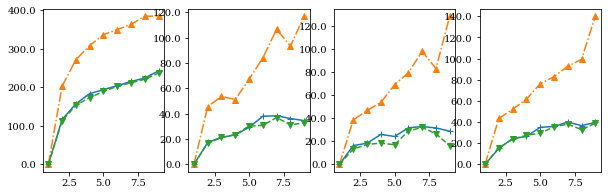

In [37]:
fig, ax = plt.subplots(1,4, figsize=(10,3))

a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming HDRF/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_volume().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming Random/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_volume().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming CLDA/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_volume().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=fmt_div_e9, pre_fig=(fig,ax[0]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 HDRF/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_volume().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 Random/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_volume().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 CLDA/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_volume().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=fmt_div_e9, pre_fig=(fig,ax[1]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 HDRF/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_volume().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 Random/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_volume().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 CLDA/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_volume().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=fmt_div_e9, pre_fig=(fig,ax[2]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 HDRF/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_volume().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 Random/",operator_name="Task-[TAIL]GNN Operator - 2",  metric_name="numBytesInRemote").get_communication_volume().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 CLDA/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_volume().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=fmt_div_e9, pre_fig=(fig,ax[3]))

### Communication Imbalance Factorfig

/tmp/ipykernel_74052/427825926.py:117: RuntimeWarning: invalid value encountered in long_scalars
  self.transform_subtasks(lambda x: np.array(max(x) / min(x)))
/tmp/ipykernel_74052/427825926.py:31: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, *args, **kwargs)
/tmp/ipykernel_74052/427825926.py:117: RuntimeWarning: invalid value encountered in long_scalars
  self.transform_subtasks(lambda x: np.array(max(x) / min(x)))
/tmp/ipykernel_74052/427825926.py:31: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, *args, **kwargs)
/tmp/ipykernel_74052/427825926.py:117: RuntimeWarning: invalid value encountered in long_scalars
  self.transform_subtasks(lambda x: np.array(max(x) / min(x)))
/tmp/ipykernel_74052/427825926.py:31: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, *args, **kwargs)
/tmp/ipykernel_74052/427825926.py:117: RuntimeWarning: invalid value encountered in long_scalars
  self.transform_subtasks(lambda x: np.array(max(x) / min(x)))
/tmp/ipyk

(<Figure size 720x216 with 4 Axes>,
 <AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7feb089e6250>])

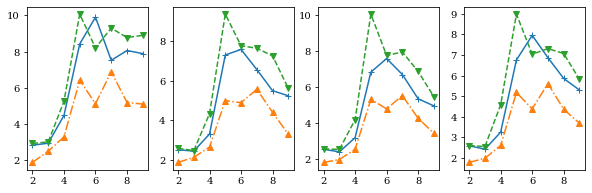

In [48]:
fig, ax = plt.subplots(1,4, figsize=(10,3))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming HDRF/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_imbalance_factor().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming Random/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_imbalance_factor().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming CLDA/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_imbalance_factor().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=None, pre_fig=(fig,ax[0]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 HDRF/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_imbalance_factor().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 Random/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_imbalance_factor().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 CLDA/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_imbalance_factor().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=None, pre_fig=(fig,ax[1]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 HDRF/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_imbalance_factor().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 Random/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_imbalance_factor().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 CLDA/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_imbalance_factor().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=None, pre_fig=(fig,ax[2]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 HDRF/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_imbalance_factor().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 Random/",operator_name="Task-[TAIL]GNN Operator - 2",  metric_name="numBytesInRemote").get_communication_imbalance_factor().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 CLDA/", operator_name="Task-[TAIL]GNN Operator - 2", metric_name="numBytesInRemote").get_communication_imbalance_factor().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=None, pre_fig=(fig,ax[3]))

### Computation Imbalance Factor

(<Figure size 720x216 with 4 Axes>,
 <AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7feb0866b2b0>])

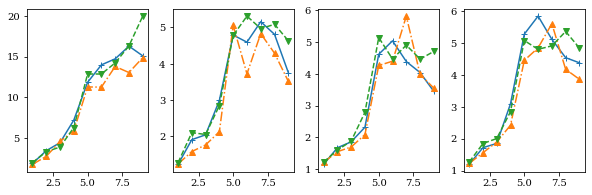

In [49]:
fig, ax = plt.subplots(1,4, figsize=(10,3))

a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming HDRF/", operator_name="Task-GNN Operator - 2", metric_name="busyTimeMsPerSecond").get_computation_imbalance_factor().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming Random/", operator_name="Task-GNN Operator - 2", metric_name="busyTimeMsPerSecond").get_computation_imbalance_factor().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming CLDA/", operator_name="Task-GNN Operator - 2", metric_name="busyTimeMsPerSecond").get_computation_imbalance_factor().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=None, pre_fig=(fig,ax[0]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 HDRF/", operator_name="Task-GNN Operator - 2", metric_name="busyTimeMsPerSecond").get_computation_imbalance_factor().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 Random/", operator_name="Task-GNN Operator - 2", metric_name="busyTimeMsPerSecond").get_computation_imbalance_factor().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 CLDA/", operator_name="Task-GNN Operator - 2", metric_name="busyTimeMsPerSecond").get_computation_imbalance_factor().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=None, pre_fig=(fig,ax[1]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 HDRF/", operator_name="Task-GNN Operator - 2", metric_name="busyTimeMsPerSecond").get_computation_imbalance_factor().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 Random/", operator_name="Task-GNN Operator - 2", metric_name="busyTimeMsPerSecond").get_computation_imbalance_factor().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 CLDA/", operator_name="Task-GNN Operator - 2", metric_name="busyTimeMsPerSecond").get_computation_imbalance_factor().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=None, pre_fig=(fig,ax[2]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 HDRF/", operator_name="Task-GNN Operator - 2", metric_name="busyTimeMsPerSecond").get_computation_imbalance_factor().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 Random/",operator_name="Task-GNN Operator - 2",  metric_name="busyTimeMsPerSecond").get_computation_imbalance_factor().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 CLDA/", operator_name="Task-GNN Operator - 2", metric_name="busyTimeMsPerSecond").get_computation_imbalance_factor().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=None, pre_fig=(fig,ax[3]))

### Runtime

(<Figure size 720x216 with 4 Axes>,
 <AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7feb0947c910>])

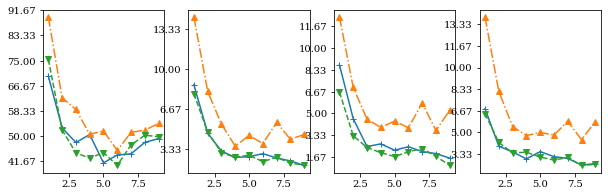

In [39]:
fig, ax = plt.subplots(1,4, figsize=(10,3))

a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming HDRF/", metric_name="numRecordsOutPerSecond").get_runtime().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming Random/", metric_name="numRecordsOutPerSecond").get_runtime().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Streaming CLDA/", metric_name="numRecordsOutPerSecond").get_runtime().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None], formatter=sec_to_min, pre_fig=(fig,ax[0]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 HDRF/", metric_name="numRecordsOutPerSecond").get_runtime().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 Random/", metric_name="numRecordsOutPerSecond").get_runtime().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Sliding-W20 CLDA/", metric_name="numRecordsOutPerSecond").get_runtime().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None],  formatter=sec_to_min, pre_fig=(fig,ax[1]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 HDRF/", metric_name="numRecordsOutPerSecond").get_runtime().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 Random/", metric_name="numRecordsOutPerSecond").get_runtime().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Session-W20 CLDA/", metric_name="numRecordsOutPerSecond").get_runtime().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None],  formatter=sec_to_min, pre_fig=(fig,ax[2]))
a1 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 HDRF/", metric_name="numRecordsOutPerSecond").get_runtime().transform_keys()
a2 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 Random/", metric_name="numRecordsOutPerSecond").get_runtime().transform_keys()
a3 = MetricStatistics(entry_folder_name="../../metrics/SX-SuperUser/Full Adaptive-W20-1 CLDA/", metric_name="numRecordsOutPerSecond").get_runtime().transform_keys()
plot_aggregated_dict(None, [a1.output, a2.output, a3.output], ["HDRF", "Random", "CLDA"], ["+", "^", "v"], [ "-", "-.", "--"], [None,None, None],  formatter=sec_to_min, pre_fig=(fig,ax[3]))

## March 27

## Process Folder

FileNotFoundError: [Errno 2] No such file or directory: '../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-random-v2n-session-50ms'

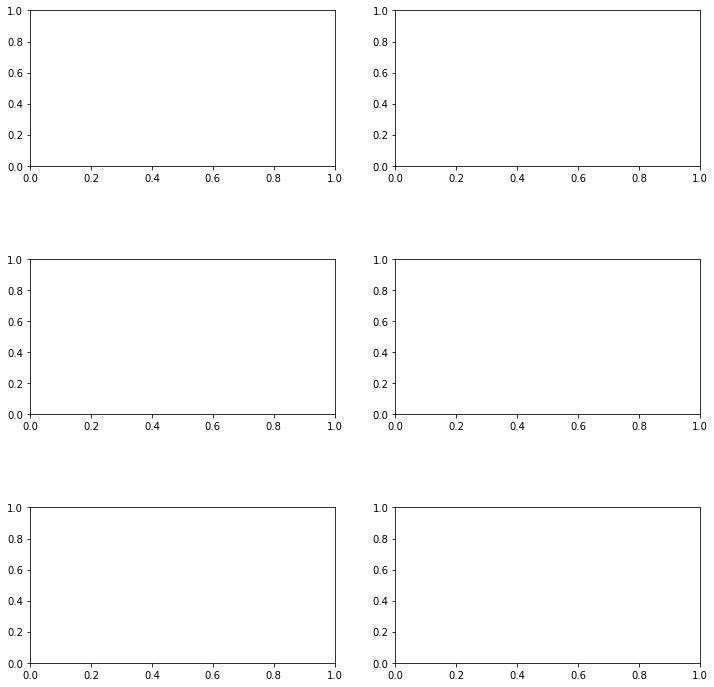

In [29]:
fig, ax = plt.subplots(3,2, figsize=(12,12), gridspec_kw={"hspace":0.6})

random_graph_runtime = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-random-v2n-session-50ms", operator_name="GNN Operator - 2", metric_name="numRecordsOutPerSecond").get_runtime()
random_hypergraph_runtime = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-hypergraph-random-session-50ms", operator_name="GNN Operator - 2", metric_name="numRecordsOutPerSecond").get_runtime()
vertex_to_net_hdrf_graph_runtime = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-hdrf-v2n-session-50ms", operator_name="GNN Operator - 2", metric_name="numRecordsOutPerSecond").get_runtime()
net_to_vertex_hdrf_graph_runtime = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-hdrf-n2v-session-50ms", operator_name="GNN Operator - 2", metric_name="numRecordsOutPerSecond").get_runtime()
minmax_hypergraph_runtime = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-hypergraph-minmax-session-50ms", operator_name="GNN Operator - 2", metric_name="numRecordsOutPerSecond").get_runtime()
plot_aggregated_dict("Runtime(minutes)", [random_graph_runtime.output, random_hypergraph_runtime.output, vertex_to_net_hdrf_graph_runtime.output, net_to_vertex_hdrf_graph_runtime.output, minmax_hypergraph_runtime.output], 
                     ["GNN(Random)","HGNN(Random)","GNN(HDRF + V2N)", "GNN(HDRF + N2V)", "HGNN(MinMax)"], ["o", "+", "+","+","+" ], ["-", "--", "-","-","--"], [None, None, None, None, None], xlabel="# Machines", formatter=sec_to_min, pre_fig=(fig,ax[0][0]))


random_graph_rf = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-random-v2n-session-50ms", operator_name="Random Partitioner", metric_name="Replication Factor").get_replication_factor()
random_hypergraph_rf = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-hypergraph-random-session-50ms", operator_name="Random Partitioner", metric_name="Replication Factor").get_replication_factor()
vertex_to_net_hdrf_graph_rf = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-hdrf-v2n-session-50ms", operator_name="HDRF[l=4.0,eps=1.0,threads=1]", metric_name="Replication Factor").get_replication_factor()
net_to_vertex_hdrf_graph_rf = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-hdrf-n2v-session-50ms", operator_name="HDRF[l=4.0,eps=1.0,threads=1]", metric_name="Replication Factor").get_replication_factor()
minmax_hypergraph_rf = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-hypergraph-minmax-session-50ms", operator_name="HyperGraphMinMax", metric_name="Replication Factor").get_replication_factor()
plot_aggregated_dict("Replication Factor", [random_graph_rf.output, random_hypergraph_rf.output, vertex_to_net_hdrf_graph_rf.output, net_to_vertex_hdrf_graph_rf.output, minmax_hypergraph_rf.output], 
                     ["GNN(Random)","HGNN(Random)","GNN(HDRF + V2N)", "GNN(HDRF + N2V)", "HGNN(MinMax)"], ["o", "+", "+","+","+" ], ["-", "--", "-","-","--"], [None, None, None, None, None], xlabel="# Machines", formatter=fmt_div_e5, pre_fig=(fig,ax[0][1]))


random_graph_maxthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-random-v2n-session-50ms", metric_name="throughput").get_max_throughput()
random_hypergraph_maxthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-hypergraph-random-session-50ms", metric_name="throughput").get_max_throughput()
vertex_to_net_hdrf_graph_maxthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-hdrf-v2n-session-50ms",  metric_name="throughput").get_max_throughput()
net_to_vertex_hdrf_graph_maxthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-hdrf-n2v-session-50ms", metric_name="throughput").get_max_throughput()
minmax_hypergraph_maxthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-hypergraph-minmax-session-50ms", metric_name="throughput").get_max_throughput()
plot_aggregated_dict("Max Throughput", [random_graph_maxthr.output, random_hypergraph_maxthr.output, vertex_to_net_hdrf_graph_maxthr.output, net_to_vertex_hdrf_graph_maxthr.output, minmax_hypergraph_maxthr.output], 
                     ["GNN(Random)","HGNN(Random)","GNN(HDRF + V2N)", "GNN(HDRF + N2V)", "HGNN(MinMax)"], ["o", "+", "+","+","+" ], ["-", "--", "-","-","--"], [None, None, None, None, None], xlabel="# Machines", formatter=fmt_div_e5, pre_fig=(fig,ax[1][0]))

random_graph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-random-v2n-session-50ms", metric_name="throughput").get_mean_throughput()
random_hypergraph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-hypergraph-random-session-50ms", metric_name="throughput").get_mean_throughput()
vertex_to_net_hdrf_graph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-hdrf-v2n-session-50ms",  metric_name="throughput").get_mean_throughput()
net_to_vertex_hdrf_graph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-hdrf-n2v-session-50ms", metric_name="throughput").get_mean_throughput()
minmax_hypergraph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-hypergraph-minmax-session-50ms", metric_name="throughput").get_mean_throughput()
plot_aggregated_dict("Mean Throughput", [random_graph_meanthr.output, random_hypergraph_meanthr.output, vertex_to_net_hdrf_graph_meanthr.output, net_to_vertex_hdrf_graph_meanthr.output, minmax_hypergraph_meanthr.output], 
                     ["GNN(Random)","HGNN(Random)","GNN(HDRF + V2N)", "GNN(HDRF + N2V)", "HGNN(MinMax)"], ["o", "+", "+","+","+" ], ["-", "--", "-","-","--"], [None, None, None, None, None], xlabel="# Machines", formatter=fmt_div_e5, pre_fig=(fig,ax[1][1]))


random_graph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-random-v2n-session-50ms",operator_name="GNN Operator - 1", metric_name="numRecordsOut").get_communication_volume()
random_hypergraph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-hypergraph-random-session-50ms",operator_name="GNN Operator - 1", metric_name="numRecordsOut").get_communication_volume()
vertex_to_net_hdrf_graph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-hdrf-v2n-session-50ms",operator_name="GNN Operator - 1",  metric_name="numRecordsOut").get_communication_volume()
net_to_vertex_hdrf_graph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-hdrf-n2v-session-50ms",operator_name="GNN Operator - 1", metric_name="numRecordsOut").get_communication_volume()
minmax_hypergraph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-hypergraph-minmax-session-50ms",operator_name="GNN Operator - 1", metric_name="numRecordsOut").get_communication_volume()
plot_aggregated_dict("Communication Vol(1)", [random_graph_meanthr.output, random_hypergraph_meanthr.output, vertex_to_net_hdrf_graph_meanthr.output, net_to_vertex_hdrf_graph_meanthr.output, minmax_hypergraph_meanthr.output], 
                     ["GNN(Random)","HGNN(Random)","GNN(HDRF + V2N)", "GNN(HDRF + N2V)", "HGNN(MinMax)"], ["o", "+", "+","+","+" ], ["-", "--", "-","-","--"], [None, None, None, None, None], xlabel="# Machines", formatter=fmt_div_e5, pre_fig=(fig,ax[2][0]))

random_graph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-random-v2n-session-50ms", metric_name="numRecordsOut").get_communication_volume()
random_hypergraph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-hypergraph-random-session-50ms", metric_name="numRecordsOut").get_communication_volume()
vertex_to_net_hdrf_graph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-hdrf-v2n-session-50ms",  metric_name="numRecordsOut").get_communication_volume()
net_to_vertex_hdrf_graph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-graph-hdrf-n2v-session-50ms", metric_name="numRecordsOut").get_communication_volume()
minmax_hypergraph_meanthr = MetricStatistics(entry_folder_name="../../metrics/AskUbuntu Graph HyperGraph Tests/ask-ubuntu-hypergraph-minmax-session-50ms", metric_name="numRecordsOut").get_communication_volume()
plot_aggregated_dict("Communication Vol(2)", [random_graph_meanthr.output, random_hypergraph_meanthr.output, vertex_to_net_hdrf_graph_meanthr.output, net_to_vertex_hdrf_graph_meanthr.output, minmax_hypergraph_meanthr.output], 
                     ["GNN(Random)","HGNN(Random)","GNN(HDRF + V2N)", "GNN(HDRF + N2V)", "HGNN(MinMax)"], ["o", "+", "+","+","+" ], ["-", "--", "-","-","--"], [None, None, None, None, None], xlabel="# Machines", formatter=fmt_div_e5, pre_fig=(fig,ax[2][1]))


# volume1_1 = MetricStatistics(entry_folder_name="../../jupyter/metrics/star_expansion_window-50/", operator_name="GNN Operator - 1", metric_name="numRecordsOut").get_communication_volume()
# volume1_2 = MetricStatistics(entry_folder_name="../../jupyter/metrics/hypergraph_window-50/", operator_name="GNN Operator - 1", metric_name="numRecordsOut").get_communication_volume()
# plot_aggregated_dict("1-layer comm", [volume1_1.output, volume1_2.output],["GNN","HGNN"], ["o", "+" ], ["-", "--"], [None, None], xlabel="# Machines", formatter=fmt_div_e5, pre_fig=(fig,ax[2][0]))

# volume2_1 = MetricStatistics(entry_folder_name="../../jupyter/metrics/star_expansion_window-50/", metric_name="numRecordsOut").get_communication_volume()
# volume2_2 = MetricStatistics(entry_folder_name="../../jupyter/metrics/hypergraph_window-50/", metric_name="numRecordsOut").get_communication_volume()
# plot_aggregated_dict("2-layer comm", [volume2_1.output, volume2_2.output],["GNN","HGNN"], ["o", "+" ], ["-", "--"], [None, None], xlabel="# Machines", formatter=fmt_div_e5, pre_fig=(fig,ax[2][1]))


fig.legend(ax[0][0].get_legend_handles_labels()[1])

## OGB_Accuracy

In [82]:
random_graph_runtime = MetricStatistics(entry_folder_name="../../metrics/ogb-products/", operator_name="GNN Operator - 3", metric_name="accuracy").get_accuracy()

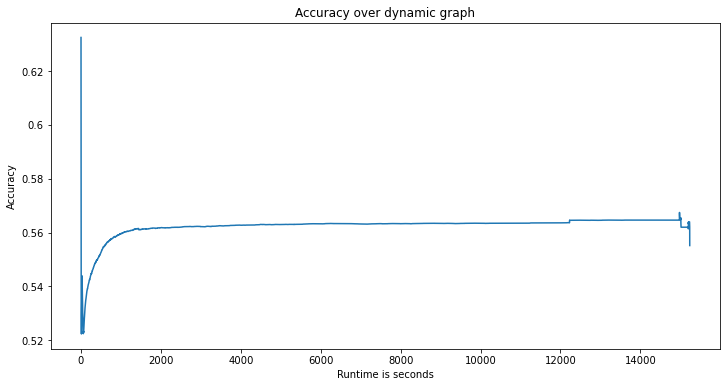

In [89]:
fig, ax = plt.subplots(figsize=(12,6))
ax.yaxis.set_major_formatter(fmt_div_e3)
ax.set_title("Accuracy over dynamic graph")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Runtime is seconds")
plt.plot(np.arange(0, random_graph_runtime.output[57].shape[0]),random_graph_runtime.output[57])
plt.savefig("accuracy")

In [79]:
random_graph_runtime = MetricStatistics(entry_folder_name="../../metrics/ogb-products/", operator_name="Parser OGB-Products", metric_name="numRecordsOut").transform_subtasks("sum_0_axis").transform_experiment("mean_0_axis")

In [80]:
np.where(random_graph_runtime.output[57] > 5000000)

(array([   67,    68,    69,    70,    71,    72,    73,    74,    75,    76,    77,    78,    79,    80,    81,    82,    83,    84,    85,    86,    87,    88,    89,    90,    91,    92,    93,    94,    95,    96,    97,    98,    99,   100,   101,   102,   103,   104,   105,   106,   107,   108,   109,   110,   111,   112,   113,   114,   115,   116,   117,   118,   119,   120,   121,   122,   123,   124,   125,   126,   127,   128,   129,   130,   131,   132,   133,   134,   135,   136,   137,   138,   139,   140,   141,   142,   143,   144,   145,   146,   147,   148,   149,   150,   151,   152,   153,   154,   155,   156,   157,   158,   159,   160,   161,   162,   163,   164,   165,   166,   167,   168,   169,   170,   171,   172,   173,   174,   175,   176,   177,   178,   179,   180,   181,   182,   183,   184,   185,   186,   187,   188,   189,   190,   191,   192,   193,   194,   195,   196,   197,   198,   199,   200,   201,   202,   203,   204,   205,   206,   207,   208